# Introduction

Here, we apply the confidence set methods to one real fMRI surface dataset from multiple people.  

This dataset was derived from the Wu-Minn HCP working memory task. Here is some further detail on the task itself.

**The Task**

In the experiment, 78 unrelated subjects performed two tasks spread across two runs where each run contained four blocks. During each block, the subject undertook either a 2-back memory task or a 0-back control task. The experimental design was arranged such that, in each run, two blocks were designated to the 2-back memory task, and two blocks were designated to the 0-back control task. In each block a subject was shown a stimuli image (a picture of a face or a place, for instance) and then asked to recall the image they were shown. They were either asked to recall the most recent image (the '0-back' image) or the image shown to them two images prior (the '2-back' image). Interest lies in assessing whether this delay impacted the \%BOLD response.

Previously, in the volume data it was 77. This is because when Tom processed it, the original sample had 80 people. 2 dropped out of the study and one did not have covariates. 

**First-level Analysis**

In FSL, a first-level analysis has been conducted independently for each subject. In each first-level analysis, the task design was regressed onto Blood Oxygenation Level Dependent (BOLD) response and a Contrast Parameter Estimate (COPE) map was generated. Each COPE map represents, for a given subject, the difference in BOLD response between the subject performing the 2-back task and the 0-back task (e.g $L\hat{\beta}=\hat{\beta}_{\text{2-Back}}-\hat{\beta}_{\text{0-Back}})$).


**Acquisition Details**

All image acquisitions were obtained using a $32$ channel head coil on a modified $3T$ Siemans Skyra scanner via a gradient-echo EPI sequence with TR $=720$ ms, TE $=33.1$ ms, $2.0$ mm slice thickness, $72$ slices, $2.0$ mm isotropic voxels, $208$ mm $\times 180$ mm FOV, and a multi-band acceleration factor of $8$.

**The Data**

You have the COPE map for each subject and the following covariates for each subject, both sorted by subject ID.
 
For more information on these variables, please visit [this link](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). Here is a brief view of the data.


In [ ]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 
#import sanssouci as ss

import pyperm as pr
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import get_data, load_img
import scipy.io

# Data Import 

Now we read the data, which were previously downloaded into the folder. 


In [2]:
# Load the .mat file
mat_data = scipy.io.loadmat('data/task67.mat')
print(type(mat_data))

<class 'dict'>


In [3]:
# a list of two 2d arrays of 32492*78
dat_ls_raw = [mat_data['left_hemisphere'], mat_data['right_hemisphere']]

In [5]:
#exclude the medial wall which will be the points at which the tstatistic is NaN
# 2796 in left and 2776 in right should be excluded 
print([np.unique(np.sum(np.isnan(dat_raw), 0)) for dat_raw in dat_ls_raw])
# for a point, it is either nan for all people or non-nan for all people
print([np.unique(np.sum(np.isnan(dat_raw), 1)) for dat_raw in dat_ls_raw])

[array([2796]), array([2776])]
[array([ 0, 78]), array([ 0, 78])]


In [6]:
# vertix, dependence between the two hemispheres, brain activitity unrelataed to  task?
dat_ls = [dat_raw[~(np.isnan(dat_raw))].reshape(-1, 78) for dat_raw in dat_ls_raw]
print('shape of the left hemisphere:', dat_ls[0].shape, 
      '\nshape of the right hemisphere:', dat_ls[1].shape)

shape of the left hemisphere: (29696, 78) 
shape of the right hemisphere: (29716, 78)


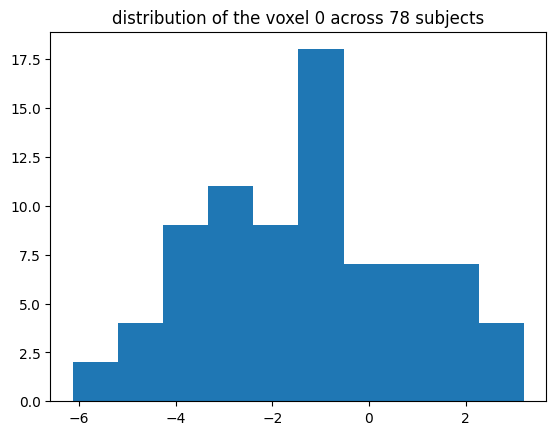

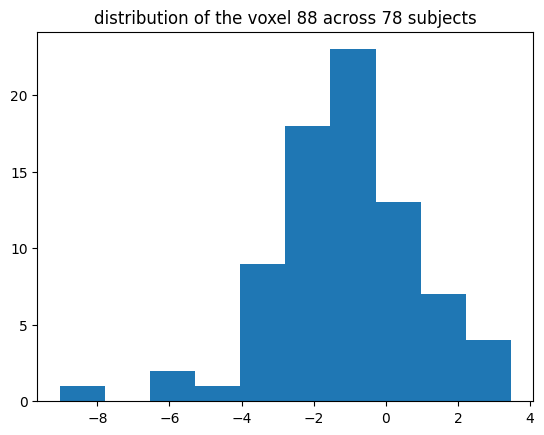

In [8]:
def plt_hist_voxel(dat, index):
    dim = dat.shape
    n_subj = dim[-1]
    plt.hist(dat[index, :].flatten())
    plt.title(f'distribution of the voxel {index} across {n_subj} subjects')
    plt.show()
plt_hist_voxel(dat_ls[0], 0)  
plt_hist_voxel(dat_ls[0], 88)  

# Confidence Set Construction

Now construct confidence sets by inverting the SCB from bootstrap. Based on the simulation results, we use t-bootstrap with rademacher multilpliers. This is done on the surface data with nan values removed. We do the analysis by concatnating the left hemisphere and right hemisphere.  

In [23]:
# concatnate the dat for two hemispheres to only get one quantile
dat_concat = np.concatenate((dat_ls[0], dat_ls[1]), axis = 0)
dat_concat.shape

(59412, 78)

In [26]:
from SimuInf.scb import confband
from SimuInf.plotting import confset_plot, ls_plot
# ensure reproducibility
np.random.seed(1)
confband_q = confband(dat_concat, m_boots=1000, return_q=True)[3]

In [27]:
confband_q

5.1585960965827695